# 0. Setup

In [1]:
import numpy as np
from numpy.testing import assert_almost_equal
import pandas as pd
from matplotlib import pyplot as plt

from scipy.optimize import minimize

from statsmodels.tsa.stattools import acf

import warnings
warnings.filterwarnings('ignore')



In [2]:
### Helper functions

def covariance_calc(H, k):
    #Calculation derived in dissertation.
    
    return 0.5\
        * (np.abs(k - 1) ** (2 * H)\
         + np.abs(k + 1) ** (2 * H)\
         - 2 * (np.abs(k) ** (2 * H)))

#Test basic functionality. Numbers calculated by hand
assert_almost_equal(covariance_calc(0.5, 1), 0)
assert_almost_equal(covariance_calc(0.25, 1), -0.2928932)
assert_almost_equal(covariance_calc(0.25, -1), -0.2928932)
assert_almost_equal(covariance_calc(0.75, 4), 0.1882461)

def get_covariance_matrix(n_steps, H):
    #Return an unscaled covariance matrix
    m = np.zeros([n_steps , n_steps])
    k = np.arange(0, n_steps, 1)

    #Calculate one column, then use this to populate rest of lower triangle of matrix
    m[:, 0] = covariance_calc(H, k)

    for i in range(1, n_steps):
        m[i:, i] = m[i-1:-1, i-1]
    
    m = np.tril(m) + np.triu(m.T, 1)
    return m

#Test matrix build right. Numbers calculated by hand. 
assert_almost_equal(get_covariance_matrix(3, 0.25), np.array([[1, -0.2928932, -0.0481881], [-0.2928932, 1, -0.2928932], [-0.0481881, -0.2928932, 1]]))

#This function needed because not all Brownian motion files start with 0, and they should for consistency
def add_zero(path):
    if path[0,] != 0:
        path = np.insert(path, 0, 0)
    return path
    
test1 = np.array([1, 2, 3])
test2 = np.array([0, -1, -2, -3])
assert_almost_equal(np.array([0, 1, 2, 3]), add_zero(test1))
assert_almost_equal(test2, add_zero(test2))

def get_diffs(path):
    # Get the differences of a path i.e. the individual increments
    return path[1:] - path[:-1]

assert_almost_equal(get_diffs(np.array([1, 1, 1, 1, 1])), np.array([0, 0, 0, 0]))
assert_almost_equal(get_diffs(np.array([1, 2, 3, 4, 5])), np.array([1, 1, 1, 1]))

#Get spot variances in spanned sets of a path
def estimate_spot_variance(S_path, span):
    #Check can divide range into equal sub-sections
    assert_almost_equal((S_path.shape[0] - 1) % span, 0)
    n_windows = (S_path.shape[0] - 1) / span

    log_returns = np.log(S_path[1:]/S_path[:-1])
    spanned_returns = np.split(log_returns, n_windows)

    spot_variances = np.zeros(int(n_windows))

    for i, v in enumerate(spanned_returns):
        spot_variances[i] = np.var(v)

    return spot_variances

test_path = np.arange(1, 22)
assert_almost_equal(estimate_spot_variance(test_path, 10), np.array([0.031131074, 0.000145955]))




In [3]:
def simulate_fbm(n_sims, n_steps, T, H):

    rng = np.random.default_rng(seed = 1729)

    cov_mat = get_covariance_matrix(n_steps, H)
    L = np.linalg.cholesky(cov_mat)
    
    variates = rng.normal(loc = 0, scale = 1, size = [n_sims, n_steps])
    corr_variates = (L @ variates.T).T

    B = np.zeros([n_sims, n_steps + 1])

    for i in range(0, n_steps):
        B[:, i + 1] = B[:, i] + corr_variates[:, i]

    return B * (T/n_steps) ** (H)


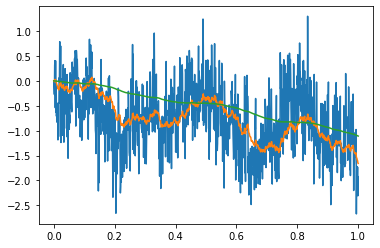

In [4]:
n_steps = 1024
T = 1

span = np.linspace(0, T, n_steps + 1)

out = simulate_fbm(1, n_steps, T, 0.05)
plt.plot(span, out.T)

out = simulate_fbm(1, n_steps, T, 0.5)
plt.plot(span, out.T)

out = simulate_fbm(1, n_steps, T, 0.95)
plt.plot(span, out.T)

# 1. MLE

In [38]:
def H_estimator(x, T):
    #return estimator of H from dissertation. Assume q = 2. 
    n_steps = x.shape[0]
    
    if x[0,] != 0:
        x = np.insert(x, 0, 0)
    diffs = diffs = x[1:] - x[:-1]

    return np.log(np.dot(diffs, diffs)) / np.log(T / n_steps)


def obj(H, x, T):
    n_steps = x.shape[0]
    R = get_covariance_matrix(n_steps, H)
    scalar = (T / n_steps) ** (2 * H)

    determinant = np.linalg.det(R)
    R_inv = np.linalg.inv(R) / scalar

    return np.log(determinant) + n_steps * np.log(scalar) + n_steps * np.log(1 / n_steps * np.dot(x.T, np.dot(R_inv, x))) 
    


def max_MLE(x, T):

    #Add x_0 value if it is missing
    if x[0,] != 0:
        x = np.insert(x, 0, 0)
    
    diffs = x[1:] - x[:-1]

    #initial_guess = H_estimator(x, T)
    initial_guess = 0.5

    #Convergence issues noticed around H = 0.95, setting a bound of 0.94
    #Set lower bound of floating epsilon to stop H hitting exactly 0, which will cause LLF errors
    H = minimize(obj, initial_guess, args = (diffs, T), bounds = [(np.finfo(float).eps, 0.94)], method = "Powell", tol = 1e-10)

    if H.success:
        H_hat = H.x[0]
        R = get_covariance_matrix(n_steps, H_hat)
        scalar = (T / n_steps) ** (2 * H_hat)
        R_inv = np.linalg.inv(R) / scalar
        sigma_hat = np.sqrt(1 / n_steps * np.dot(diffs.T, np.dot(R_inv, diffs)))
        return H_hat, sigma_hat

    return H.success

In [22]:
# Check this code works for a selection of cases

test_vals = np.arange(0.05, 0.9, 0.05)
test_scalars = np.arange(0.5, 2, 0.5)
val_errors = np.zeros((test_vals.shape[0], test_scalars.shape[0]))
scalar_errors = np.zeros((test_vals.shape[0], test_scalars.shape[0]))
for i, i_val in enumerate(test_vals):
    for j, j_val in enumerate(test_scalars):
        test_sim = simulate_fbm(1, 1024, 1, i_val)
        test_sim = test_sim[0, :].T * j_val
        test_H = max_MLE(test_sim, 1)
        val_errors[i, j] = test_H[0] - i_val
        scalar_errors[i, j] = test_H[1] - j_val
    

0.05
0.5
1.0
1.5
0.1
0.5
1.0
1.5
0.15000000000000002
0.5
1.0
1.5
0.2
0.5
1.0
1.5
0.25
0.5
1.0
1.5
0.3
0.5
1.0
1.5
0.35000000000000003
0.5
1.0
1.5
0.4
0.5
1.0
1.5
0.45
0.5
1.0
1.5
0.5
0.5
1.0
1.5
0.55
0.5
1.0
1.5
0.6000000000000001
0.5
1.0
1.5
0.6500000000000001
0.5
1.0
1.5
0.7000000000000001
0.5
1.0
1.5
0.7500000000000001
0.5
1.0
1.5
0.8
0.5
1.0
1.5
0.8500000000000001
0.5
1.0
1.5


In [23]:
val_errors

array([[ 0.00136475,  0.00136475,  0.00136475],
       [ 0.00036356,  0.00036353,  0.00036354],
       [-0.00061258, -0.00061258, -0.00061258],
       [-0.00136381, -0.0013638 , -0.00136381],
       [-0.00191366, -0.00191364, -0.00191364],
       [-0.00231321, -0.00231321, -0.00231319],
       [-0.00260784, -0.00260788, -0.00260785],
       [-0.00283253, -0.00283256, -0.00283256],
       [-0.00301345, -0.00301342, -0.00301342],
       [-0.00317011, -0.00317004, -0.00317009],
       [-0.00331787, -0.00331769, -0.00331773],
       [-0.00346964, -0.00346955, -0.00346969],
       [-0.00363918, -0.00363885, -0.00363901],
       [-0.0038411 , -0.0038411 , -0.00384144],
       [-0.00410053, -0.00410058, -0.00409967],
       [-0.00445711, -0.00445669, -0.00445864],
       [-0.00499504, -0.00499586, -0.00499678]])

In [24]:
scalar_errors

array([[ 8.15713600e-03,  1.63142335e-02,  2.44713549e-02],
       [ 5.42028591e-03,  1.08403945e-02,  1.62606865e-02],
       [ 2.44279083e-03,  4.88558078e-03,  7.32836101e-03],
       [ 3.53524746e-05,  7.07588409e-05,  1.06022729e-04],
       [-1.79905717e-03, -3.59801048e-03, -5.39702082e-03],
       [-3.19067704e-03, -6.38132490e-03, -9.57184877e-03],
       [-4.27139502e-03, -8.54302239e-03, -1.28142524e-02],
       [-5.14975483e-03, -1.02996731e-02, -1.54495172e-02],
       [-5.91203531e-03, -1.18238974e-02, -1.77358206e-02],
       [-6.62812491e-03, -1.32557728e-02, -1.98842136e-02],
       [-7.35999932e-03, -1.47187849e-02, -2.20786310e-02],
       [-8.16963953e-03, -1.63386061e-02, -2.45094054e-02],
       [-9.13546660e-03, -1.82685529e-02, -2.74046373e-02],
       [-1.03636698e-02, -2.07273395e-02, -3.10948975e-02],
       [-1.20500273e-02, -2.41004533e-02, -3.61400505e-02],
       [-1.45668753e-02, -2.91302748e-02, -4.37197416e-02],
       [-1.88095312e-02, -3.76264623e-02

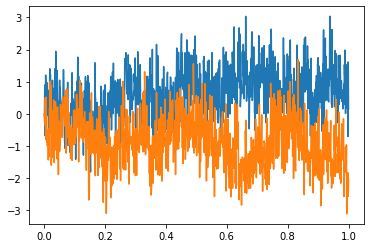

In [42]:
sample_fbm = np.loadtxt('C:\\Users\\jamma\\Masters\\Dissertation\\fBMPath2.txt')
res = max_MLE(sample_fbm, 1)

plt.plot(span[1:], sample_fbm)

out = simulate_fbm(1, 1024, 1, res[0])
plt.plot(span, out.T * res[1])


# 2. Simulation

In [46]:
B_path_loc = 'C:\\Users\\jamma\\Masters\\Dissertation\\Bpath.05.txt'
BH_path_loc = 'C:\\Users\\jamma\\Masters\\Dissertation\\BHpath.05.txt'
W_path_loc = 'C:\\Users\\jamma\\Masters\\Dissertation\\Wpath.05.txt'


def simulate_RFSV(B_path_loc, BH_path_loc, W_path_loc):
    B_path = add_zero(np.loadtxt(B_path_loc))
    BH_path = add_zero(np.loadtxt(BH_path_loc))
    W_path = add_zero(np.loadtxt(W_path_loc))

    B_diffs = get_diffs(B_path)
    W_diffs = get_diffs(W_path)

    n_steps = B_diffs.shape[0]

    S_path = np.zeros(n_steps + 1)
    V_path = np.zeros(n_steps + 1)

    V0 = 0.1
    v = 1
    rho = -0.65
    rho_bar = np.sqrt(1 - rho ** 2)

    V_path = V0 * np.exp(v * BH_path)

    # Assume some values for S0, V0
    S_path[0] = 1
    
    for i in range(n_steps):
        S_path[i + 1] = S_path[i] *\
              (1 + np.sqrt(V_path[i]) *\
              (rho * B_diffs[i] + rho_bar * W_diffs[i]))
        
    return V_path, S_path


V_path, S_path = simulate_RFSV(B_path_loc, BH_path_loc, W_path_loc)

estimate_spot_variance(V_path, 16)

array([0.65961145, 0.31548865, 0.52738173, ..., 0.36177651, 0.30971986,
       0.40212803])